In [1]:
!pip install ultralytics

import os
import yaml
from shutil import copytree, ignore_patterns
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [2]:
train_path = "/kaggle/input/fruit-images-for-object-detection/train_zip/train"
test_path = "/kaggle/input/fruit-images-for-object-detection/test_zip/test"
train_files_images = [f for f in os.listdir(train_path) if f.endswith('.jpg')]
train_files_annotations = [f for f in os.listdir(train_path) if f.endswith('.xml')]
test_files_images = [f for f in os.listdir(test_path) if f.endswith('.jpg')]
test_files_annotations = [f for f in os.listdir(test_path) if f.endswith('.xml')]

In [3]:
print(f'Training files: {len(train_files_images)}')
print(f'Testing files: {len(test_files_images)}')

Training files: 240
Testing files: 60


In [4]:
base_dir = '/kaggle/working/object_detection'
for folder in ['train/images', 'train/labels', 'test/images', 'test/labels']:
    os.makedirs(os.path.join(base_dir, folder), exist_ok=True)

In [5]:
copytree(train_path, os.path.join(base_dir, 'train/images'), ignore=ignore_patterns('*.xml'), dirs_exist_ok=True)
copytree(test_path, os.path.join(base_dir, 'test/images'), ignore=ignore_patterns('*.xml'), dirs_exist_ok=True)

'/kaggle/working/object_detection/test/images'

In [6]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

# Class mapping
class_map = {'apple': 0, 'banana': 1, 'orange': 2}

def convert_bbox(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x_center = (box[0] + box[2]) / 2.0
    y_center = (box[1] + box[3]) / 2.0
    width = box[2] - box[0]
    height = box[3] - box[1]
    return [x_center * dw, y_center * dh, width * dw, height * dh]

def convert_annotation(file_path, output_folder):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    filename = root.find('filename').text
    image_path = os.path.join(os.path.dirname(file_path), filename)

    image = Image.open(image_path)
    width, height = image.size

    yolo_lines = []
    for obj in root.iter('object'):
        cls = obj.find('name').text
        if cls not in class_map:
            continue
        cls_id = class_map[cls]
        xml_box = obj.find('bndbox')
        b = [int(xml_box.find(tag).text) for tag in ('xmin', 'ymin', 'xmax', 'ymax')]
        yolo_box = convert_bbox((width, height), b)
        yolo_line = f"{cls_id} " + " ".join([f"{x:.6f}" for x in yolo_box])
        yolo_lines.append(yolo_line)

    os.makedirs(output_folder, exist_ok=True)
    txt_filename = os.path.splitext(os.path.basename(file_path))[0] + '.txt'
    with open(os.path.join(output_folder, txt_filename), 'w') as f:
        f.write('\n'.join(yolo_lines))

# Example usage
data_dir = '/kaggle/input/fruit-images-for-object-detection/train_zip/train'
output_dir = '/kaggle/working/object_detection/train/labels'

for file in os.listdir(data_dir):
    if file.endswith('.xml'):
        xml_path = os.path.join(data_dir, file)
        convert_annotation(xml_path, output_dir)

In [7]:
data_yaml = """
train: /kaggle/working/object_detection/train/images
val: /kaggle/working/object_detection/test/images

nc: 3
names: ['apple', 'banana', 'orange']
"""

with open('/kaggle/working/object_detection/data.yaml', 'w') as f:
    f.write(data_yaml.strip())

In [8]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')  
model.train(
    data='/kaggle/working/object_detection/data.yaml',
    epochs=20,
    imgsz=640,
    batch=16
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 84.0MB/s]


Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/object_detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

100%|██████████| 755k/755k [00:00<00:00, 17.2MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 72.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1030.2±640.0 MB/s, size: 87.7 KB)


train: Scanning /kaggle/working/object_detection/train/labels... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 1145.66it/s]

train: /kaggle/working/object_detection/train/images/apple_62.jpg: corrupt JPEG restored and saved
train: New cache created: /kaggle/working/object_detection/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 795.8±944.9 MB/s, size: 227.1 KB)


val: Scanning /kaggle/working/object_detection/test/labels... 0 images, 60 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 2081.16it/s]

WARNING ⚠️ val: No labels found in /kaggle/working/object_detection/test/labels.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
val: New cache created: /kaggle/working/object_detection/test/labels.cache
WARNING ⚠️ Labels are missing or empty in /kaggle/working/object_detection/test/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to runs/detect/train/labels.jpg... 


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/15 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
       1/20      2.03G      1.294      3.155      1.596         68        640:  20%|██        | 3/15 [00:01<00:05,  2.15it/s]libpng warning: iCCP: known incorrect sRGB profile
       1/20      2.05G      1.243      3.137      1.576         56        640:  47%|████▋     | 7/15 [00:02<00:02,  3.68it/s]libpng warning: iCCP: known incorrect sRGB profile
       1/20      2.05G      1.219      3.132       1.57         60        640:  53%|█████▎    | 8/15 [00:02<00:01,  3.98it/s]libpng warning: iCCP: known incorrect sRGB profile
       1/20      2.05G      1.204      2.993      1.542         66        640: 100%|██████████| 15/15 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  4.25it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R    

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.54G      1.028        2.3      1.373         73        640:  27%|██▋       | 4/15 [00:00<00:01,  6.05it/s]libpng warning: iCCP: known incorrect sRGB profile
       2/20      2.54G      1.056      2.186      1.397         72        640:  60%|██████    | 9/15 [00:01<00:00,  6.43it/s]libpng warning: iCCP: known incorrect sRGB profile
       2/20      2.54G      1.074      2.079      1.409         66        640: 100%|██████████| 15/15 [00:02<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.55G      1.077       1.75      1.371         73        640:  13%|█▎        | 2/15 [00:00<00:01,  6.86it/s]libpng warning: iCCP: known incorrect sRGB profile
       3/20      2.55G      1.096      1.698      1.408         64        640:  53%|█████▎    | 8/15 [00:01<00:01,  6.63it/s]libpng warning: iCCP: known incorrect sRGB profile
       3/20      2.55G      1.077      1.675      1.385         56        640:  60%|██████    | 9/15 [00:01<00:00,  6.24it/s]libpng warning: iCCP: known incorrect sRGB profile
       3/20      2.55G      1.107      1.677      1.409         59        640:  93%|█████████▎| 14/15 [00:02<00:00,  5.63it/s]libpng warning: iCCP: known incorrect sRGB profile
       3/20      2.55G       1.11      1.679      1.412         57        640: 100%|██████████| 15/15 [00:02<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  5.39it/s]libpng warning: iCCP: known incor

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.57G      1.104      1.529      1.395         65        640:  87%|████████▋ | 13/15 [00:02<00:00,  5.11it/s]libpng warning: iCCP: known incorrect sRGB profile
       4/20      2.57G      1.098      1.507      1.386         68        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.59G      1.019        1.3      1.332         63        640:  13%|█▎        | 2/15 [00:00<00:01,  7.10it/s]libpng warning: iCCP: known incorrect sRGB profile
       5/20      2.59G      1.035       1.39      1.327         80        640:  73%|███████▎  | 11/15 [00:01<00:00,  6.14it/s]libpng warning: iCCP: known incorrect sRGB profile
       5/20      2.59G      1.044      1.387      1.334         61        640:  93%|█████████▎| 14/15 [00:02<00:00,  5.14it/s]libpng warning: iCCP: known incorrect sRGB profile
       5/20      2.59G      1.044      1.382      1.333         80        640: 100%|██████████| 15/15 [00:02<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  6.42it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.6G     0.9649      1.236      1.262         72        640:   7%|▋         | 1/15 [00:00<00:01,  7.60it/s]libpng warning: iCCP: known incorrect sRGB profile
       6/20      2.61G      1.084      1.395      1.361         69        640: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
libpng warning: iCCP: known incorrect sRGB profile



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.62G      1.117      1.417      1.367         79        640:  20%|██        | 3/15 [00:00<00:01,  6.59it/s]libpng warning: iCCP: known incorrect sRGB profile
       7/20      2.62G      1.079      1.399      1.357         71        640:  27%|██▋       | 4/15 [00:00<00:01,  6.70it/s]libpng warning: iCCP: known incorrect sRGB profile
       7/20      2.62G      1.049      1.379      1.326         77        640:  47%|████▋     | 7/15 [00:01<00:01,  6.56it/s]libpng warning: iCCP: known incorrect sRGB profile
       7/20      2.62G      1.027      1.321      1.305         74        640: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  6.95it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.64G      1.086      1.305      1.367         56        640:  33%|███▎      | 5/15 [00:00<00:01,  6.61it/s]libpng warning: iCCP: known incorrect sRGB profile
       8/20      2.64G      1.073      1.325      1.353         88        640:  53%|█████▎    | 8/15 [00:01<00:01,  6.29it/s]libpng warning: iCCP: known incorrect sRGB profile
       8/20      2.64G      1.064      1.303      1.354         80        640: 100%|██████████| 15/15 [00:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  6.09it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.66G      1.009      1.283      1.297         63        640:  33%|███▎      | 5/15 [00:00<00:01,  6.44it/s]libpng warning: iCCP: known incorrect sRGB profile
       9/20      2.66G      1.008       1.26      1.298         65        640:  47%|████▋     | 7/15 [00:01<00:01,  6.62it/s]libpng warning: iCCP: known incorrect sRGB profile
       9/20      2.66G      1.012      1.278      1.309         67        640:  73%|███████▎  | 11/15 [00:01<00:00,  5.34it/s]libpng warning: iCCP: known incorrect sRGB profile
       9/20      2.66G     0.9982      1.251      1.306         81        640: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  6.96it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.67G     0.9805      1.161      1.289         78        640:  33%|███▎      | 5/15 [00:00<00:01,  6.43it/s]libpng warning: iCCP: known incorrect sRGB profile
      10/20      2.67G     0.9531      1.141      1.276         45        640: 100%|██████████| 15/15 [00:02<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  6.88it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.69G     0.8145      1.348      1.206         28        640:   7%|▋         | 1/15 [00:00<00:07,  2.00it/s]libpng warning: iCCP: known incorrect sRGB profile
      11/20      2.69G     0.9189      1.468      1.297         31        640:  13%|█▎        | 2/15 [00:00<00:04,  2.82it/s]libpng warning: iCCP: known incorrect sRGB profile
      11/20      2.69G     0.9629      1.583      1.332         39        640:  27%|██▋       | 4/15 [00:01<00:02,  3.83it/s]libpng warning: iCCP: known incorrect sRGB profile
      11/20      2.69G     0.9741      1.514      1.346         29        640:  53%|█████▎    | 8/15 [00:01<00:01,  5.22it/s]libpng warning: iCCP: known incorrect sRGB profile
      11/20      2.69G     0.9316      1.522      1.319         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.71G      1.156      1.717      1.519         24        640:   7%|▋         | 1/15 [00:00<00:01,  7.49it/s]libpng warning: iCCP: known incorrect sRGB profile
      12/20      2.71G     0.9439      1.411      1.331         27        640: 100%|██████████| 15/15 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
libpng warning: iCCP: known incorrect sRGB profile



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.72G     0.9284      1.313       1.31         22        640:  20%|██        | 3/15 [00:00<00:01,  7.21it/s]libpng warning: iCCP: known incorrect sRGB profile
      13/20      2.72G     0.8984        1.3      1.307         33        640:  33%|███▎      | 5/15 [00:00<00:01,  6.59it/s]libpng warning: iCCP: known incorrect sRGB profile
      13/20      2.73G     0.8887      1.288      1.305         28        640:  93%|█████████▎| 14/15 [00:02<00:00,  6.50it/s]libpng warning: iCCP: known incorrect sRGB profile
      13/20      2.73G     0.9022      1.302      1.312         37        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
libpng warning: iCCP: known incorrect sRGB profile



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.74G     0.8434      1.256       1.27         33        640:  27%|██▋       | 4/15 [00:00<00:01,  7.24it/s]libpng warning: iCCP: known incorrect sRGB profile
      14/20      2.74G     0.8878       1.27      1.263         25        640:  73%|███████▎  | 11/15 [00:01<00:00,  6.77it/s]libpng warning: iCCP: known incorrect sRGB profile
      14/20      2.74G     0.8716      1.255      1.251         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.91it/s]
libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  6.31it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.76G     0.8157       1.11      1.204         28        640:  13%|█▎        | 2/15 [00:00<00:01,  6.75it/s]libpng warning: iCCP: known incorrect sRGB profile
      15/20      2.76G     0.8012      1.204      1.224         24        640:  33%|███▎      | 5/15 [00:00<00:01,  6.81it/s]libpng warning: iCCP: known incorrect sRGB profile
      15/20      2.76G     0.8396      1.199      1.213         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  7.04it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/15 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      16/20      2.78G     0.8245      1.065      1.217         34        640:  20%|██        | 3/15 [00:00<00:01,  6.35it/s]libpng warning: iCCP: known incorrect sRGB profile
      16/20      2.78G     0.8271       1.09      1.221         37        640: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  7.50it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.79G     0.8049      1.221      1.252         28        640:  13%|█▎        | 2/15 [00:00<00:01,  7.25it/s]libpng warning: iCCP: known incorrect sRGB profile
      17/20      2.79G     0.7916      1.089      1.181         34        640:  67%|██████▋   | 10/15 [00:01<00:00,  6.95it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
      17/20      2.79G      0.793       1.06      1.178         36        640:  87%|████████▋ | 13/15 [00:02<00:00,  6.06it/s]libpng warning: iCCP: known incorrect sRGB profile
      17/20      2.79G     0.8003      1.076      1.191         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
libpng warning: iCCP: known incorrect sRGB profile



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.81G      0.774      1.002      1.139         32        640:  40%|████      | 6/15 [00:00<00:01,  5.95it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
      18/20      2.81G     0.7582      1.024       1.16         28        640: 100%|██████████| 15/15 [00:02<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
libpng warning: iCCP: known incorrect sRGB profile



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.83G     0.7451     0.9675      1.136         32        640:  13%|█▎        | 2/15 [00:00<00:01,  6.66it/s]libpng warning: iCCP: known incorrect sRGB profile
      19/20      2.83G     0.7363      1.009      1.134         37        640:  80%|████████  | 12/15 [00:01<00:00,  6.30it/s]libpng warning: iCCP: known incorrect sRGB profile
      19/20      2.83G     0.7519          1      1.156         36        640: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
libpng warning: iCCP: known incorrect sRGB profile



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.85G     0.7566      1.066      1.241         31        640:  27%|██▋       | 4/15 [00:00<00:01,  6.82it/s]libpng warning: iCCP: known incorrect sRGB profile
      20/20      2.85G     0.7622      1.026      1.209         36        640:  47%|████▋     | 7/15 [00:01<00:01,  6.44it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
      20/20      2.85G     0.7335     0.9659      1.157         29        640: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  7.18it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:765: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



20 epochs completed in 0.019 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  8.08it/s]libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:583: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:628: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/li

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([], dtype=int64)
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c1d404f1bd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        


image 1/1 /kaggle/working/object_detection/test/images/mixed_25.jpg: 480x640 1 apple, 1 orange, 35.2ms
Speed: 1.9ms preprocess, 35.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


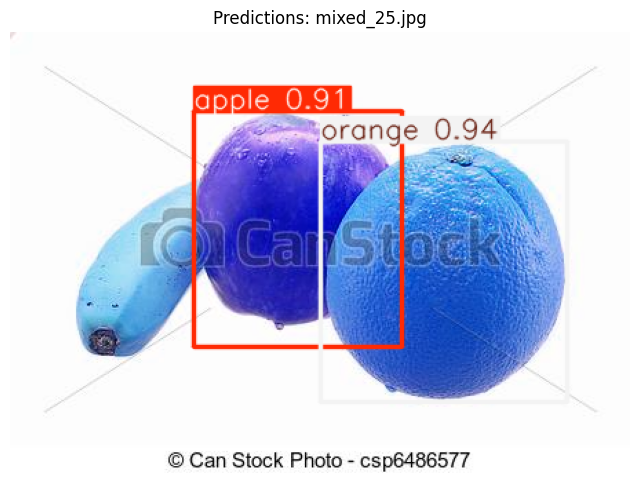


image 1/1 /kaggle/working/object_detection/test/images/mixed_22.jpg: 640x640 1 banana, 1 orange, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


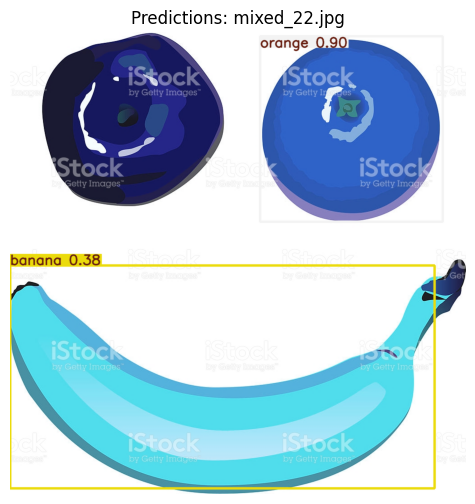


image 1/1 /kaggle/working/object_detection/test/images/orange_80.jpg: 480x640 1 orange, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


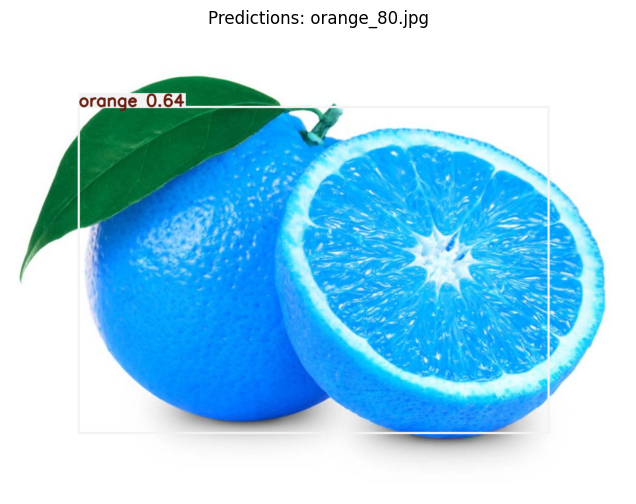


image 1/1 /kaggle/working/object_detection/test/images/apple_78.jpg: 640x640 1 apple, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


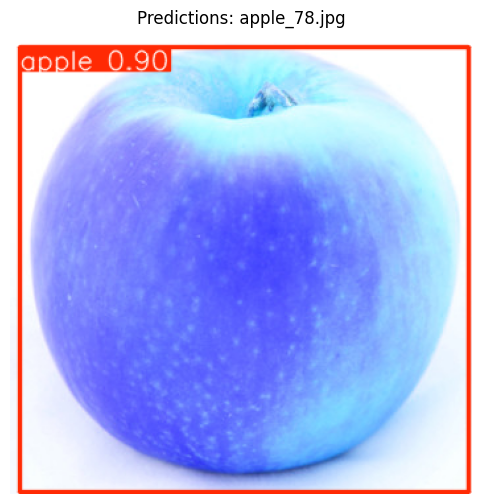


image 1/1 /kaggle/working/object_detection/test/images/apple_85.jpg: 512x640 1 apple, 37.4ms
Speed: 2.7ms preprocess, 37.4ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


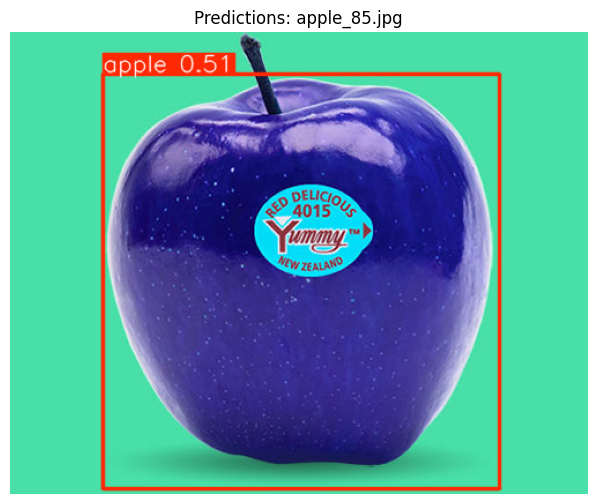

In [9]:
test_images_dir = '/kaggle/working/object_detection/test/images'
image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png'))]

for img_file in image_files[:5]:  
    img_path = os.path.join(test_images_dir, img_file)
    results = model(img_path)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    annotated_frame = results[0].plot()  
    plt.figure(figsize=(8, 6))
    plt.imshow(annotated_frame)
    plt.title(f"Predictions: {img_file}")
    plt.axis('off')
    plt.show()

In [10]:
output_label_dir = '/kaggle/working/object_detection/test/labels'
os.makedirs(output_label_dir, exist_ok=True)

for img_file in image_files:
    img_path = os.path.join(test_images_dir, img_file)
    results = model(img_path)
    result = results[0]

    # Get prediction info
    boxes = result.boxes
    if boxes is not None:
        with open(os.path.join(output_label_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt')), 'w') as f:
            for box in boxes:
                cls = int(box.cls.cpu().numpy())
                xywh = box.xywhn.cpu().numpy().flatten()  # Normalized center_x, center_y, w, h
                line = f"{cls} {' '.join(map(lambda x: f'{x:.6f}', xywh))}\n"
                f.write(line)


image 1/1 /kaggle/working/object_detection/test/images/mixed_25.jpg: 480x640 1 apple, 1 orange, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /kaggle/working/object_detection/test/images/mixed_22.jpg: 640x640 1 banana, 1 orange, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/object_detection/test/images/orange_80.jpg: 480x640 1 orange, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /kaggle/working/object_detection/test/images/apple_78.jpg: 640x640 1 apple, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/object_detection/test/images/apple_85.jpg: 512x640 1 apple, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /kaggle/working/obj

/tmp/ipykernel_35/1151807088.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(box.cls.cpu().numpy())
libpng warning: iCCP: known incorrect sRGB profile


image 1/1 /kaggle/working/object_detection/test/images/apple_95.jpg: 416x640 5 apples, 44.3ms
Speed: 2.6ms preprocess, 44.3ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /kaggle/working/object_detection/test/images/apple_80.jpg: 544x640 1 apple, 37.7ms
Speed: 2.5ms preprocess, 37.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /kaggle/working/object_detection/test/images/apple_92.jpg: 640x640 1 apple, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/object_detection/test/images/orange_78.jpg: 320x640 1 orange, 39.0ms
Speed: 1.5ms preprocess, 39.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /kaggle/working/object_detection/test/images/banana_92.jpg: 640x640 1 banana, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/object_detection